# Aggregation Volume Bias per lo studio di Sticky Hard Spheres

I sistemi fortemente associati costituiscono una classe importante di sistemi caratterizzati da attrazioni dovute a buche di potenziale profonde e strette, solitamente causate dalla formazione di legami intermolecolari. Questi sistemi mostrano forti deviazioni dal comportamento di un gas ideale proprio a causa della formazione di cluster. \
Esempi tipici sono gli acidi organici, gli alcoli e altre molecole capaci di formare legami a idrogeno. Per molto tempo, il comportamento non ideale di questi sistemi è stato spiegato utilizzando un punto di vista "chimico", ossia in termini della formazione di nuove specie chimiche. Tuttavia, lo sviluppo e il progresso nei trattamenti teorici e computazionali per questi sistemi ha riportato l'attenzione sulla natura "fisica" dell'associazione, ovvero sulle forze intermolecolari che solitamente vengono rappresentate da interazioni elettrostatiche fortemente attrattive e orientate. 

Vogliamo, perciò, presentare un esempio di algoritmo Monte Carlo biased attraverso il cosiddetto volume di aggregazione (AVB MC), che migliora significativamente l'efficienza del campionamento dello spazio delle fasi nei sistemi composti da particelle fortemente associate. L'algoritmo AVB MC, sviluppato da Bin Chen e J. Ilja Siepmann nel 2000, è facile da implementare, generalmente applicabile e robusto. Mostreremo, infine, la sua efficienza attraverso lo studio di un sistema di particelle dure con potenziale di interazione a buca quadrata, chiamate anche sticky hard spheres system.


La precisione dei risultati di una simulazione dipende esclusivamente dall'estensione con cui lo spazio delle fasi del sistema viene campionato durante la simulazione. Nella pratica, la lunghezza finita delle simulazioni può portare a un campionamento inadeguato delle regioni rilevanti dello spazio delle fasi a causa di colli di bottiglia o trappole nello spazio delle configurazioni. In particolare, nei sistemi fortemente associati, le configurazioni "legate" risultano essere delle trappole, cioè configurazioni con un peso di Boltzmann molto elevato associato al favorevole guadagno, diminuzione, di energia dovuto alla formazione di un cluster. Tuttavia, queste configurazioni "legate" rappresentano solo una piccola frazione dell'intero spazio delle fasi rispetto all'enorme numero di configurazioni non legate. \
Pertanto, un algoritmo di campionamento efficiente deve essere in grado di trovare queste trappole senza rimanerne bloccato per poter continuare ad esplorare le possibili configurazioni del sistema. 

L'algoritmo standard Monte Carlo di Metropolis, utilizzato nella maggior parte delle simulazioni molecolari, fallisce per i sistemi fortemente associati poiché utilizza una matrice di Markov simmetrica e la sua probabilità di accettazione si basa esclusivamente sul peso di Boltzmann legato alla differenza di energia tra la nuova configurazione proposta e quella attuale. La simmetria della matrice porta a una bassa efficienza nel localizzare le poche configurazioni legate in un vasto mare di spazio delle fasi dominato da configurazioni non legate. Inoltre, la regola standard di accettazione rende la distruzione delle configurazioni legate, che portano un importante guadagno energetico, un processo molto lento e svantaggioso. \
Per superare questo problema, diversi gruppi di ricerca hanno introdotto algoritmi con bias, tutti basati su modifiche della matrice di transizione di Markov sottostante e, di conseguenza, anche della regola di accettazione: la matrice di Markov modificata è progettata per favorire la formazione di configurazioni legate e allo stesso tempo il bias introdotto regola il tasso di accettazione in modo da permettere anche la rottura dei legami.


## 1. Algoritmo MonteCarlo con Aggregation-Volume-Bias

Presentiamo ora l’Algoritmo di Aggregation Volume Bias MC in termini di simulazioni nell'insieme canonico NTV. In questo caso, l'algoritmo AVB MC introduce una nuova trial move che comporta l’inserimento o la rimozione di una particella dal volume di aggregazione di un'altra particella scelta casualmente. Queste mosse sono finalizzate al campionamento della formazione o distruzione di cluster, mentre le tradizionali trial move traslazionali e, se necessario, rotazionali vengono utilizzate per esplorare regioni vicine dello spazio delle fasi.

### 1.1 Metropolis standard

Per confronto, iniziamo con il breve schema di una mossa traslazionale unbiased. Partendo da una configurazione data del sistema, stato A, la mossa traslazionale di Metropolis procede come segue:
1. Si seleziona casualmente una particella i;
2. Si propone uno spostamento della particella i che porta alla configurazione di trial, stato B, dove il vettore di spostamento è estratto casualmente da una distribuzione uniforme limitata tra zero ed uno spostamento traslazionale massimo, il quale deve essere ottimizzato per massimizzare l'efficienza del campionamento;
3. Si calcola la differenza di energia potenziale, $\Delta U = U_B - U_A$ e si accetta questa mossa con probabilità:

$$acceptance(A \rightarrow B) = min\left(1, exp{\left(-\frac{\Delta U}{k_BT}\right)}\right)$$

dove $k_B$ e $T$ sono rispettivamente la costante di Boltzmann e la temperatura assoluta. È poi banale dimostrare che lo schema di Metropolis soddisfa la condizione di reversibilità microscopica cioè il bilancio dettagliato:

$$\rho_A \times \alpha (A \rightarrow B) \times acc(A \rightarrow B) = \rho_B \times \alpha (B \rightarrow A) \times acc(B \rightarrow A) $$

dato che si utilizza una matrice di Markov simmetrica, si ha che $\alpha (A \rightarrow B) = \alpha (B \rightarrow A)$  e la densità di probabilità $\rho$ di qualsiasi stato dato è proporzionale al suo peso di Boltzmann.


Tuttavia, lo schema di Metropolis è chiaramente non efficiente per passare tra configurazioni legate e non legate, come richiesto per i sistemi fortemente associati.
In primis, a causa del piccolo volume dello spazio delle fasi occupato dalle configurazioni legate (rispetto al volume totale dello spazio delle fasi), la probabilità di tentare una mossa che vada da una configurazione non legata a una legata è molto bassa.
In secondo luogo, una volta trovata una configurazione legata, qualsiasi trial move che porti alla distruzione di tale configurazione avrà un tasso di accettazione molto basso a causa della grande differenza di energia tra questi due stati: infatti, la creazione di un legame porta un tale vantaggio energetico che qualsiasi tentativo di romperlo verrà rifiutato.

Pertanto, durante una simulazione Monte Carlo con lo schema di Metropolis per un sistema fortemente associato, la traiettoria nello spazio delle fasi potrebbe non riuscire a formare configurazioni legate oppure rimanere intrappolata una volta che ne trova una. Di conseguenza, campionare adeguatamente lo spazio delle fasi per ottenere configurazioni affidabili e indipendenti su cui calcolare le medie di ensemble richiederà un tempo di simulazione eccessivamente lungo, rendendo la simulazione estremamente inefficiente.

Il problema del campionamento con lo schema di Metropolis è evidente, così come è chiara la direzione generale per risolverlo: aumentare la probabilità di transizione per le mosse che portano alla formazione di configurazioni legate e migliorare il tasso di accettazione per le mosse che portano alla loro distruzione. Questo è esattamente lo scopo dell’introduzione di metodi di biasing in una simulazione Monte Carlo.

### 1.2 Metodi di Biasing

In generale, i metodi di biasing vengono introdotti proprio per effettuare un campionamento più veloce dello spazio delle configurazioni di un sistema: si introducono, perciò, mosse non necessariamente fisiche per calcolare in maniera più efficiente le medie statistiche delle osservabili del sistema studiato. Nonostante le mosse di biasing rivestano un ruolo chiave in molte simulazioni Montecarlo, esse accompagnano e non sostituiscono le tradizionali mosse di traslazione; se, infatti, usassimo solo mosse biased questo porterebbe ad avere un sistema non ergodico.

Il biasing si basa sul concetto di effettuare trial move non simmetriche in cui quindi $\alpha\, (old \rightarrow new) \neq \alpha\, (new \rightarrow old)$ e ciò porta importanti conseguenze sull’acceptance delle configurazioni proposte. Partendo dal bilancio dettagliato:

$$\rho\,(old) \times \Pi\,(old \rightarrow new) = \rho\,(new) \times \Pi\,(new \rightarrow old) $$

il Montecarlo Metropolis prevede che la matrice di transizione $ \Pi $ tra due stati del sistema venga fattorizzata in:

$$\Pi\, (old \rightarrow new) = \alpha\, (old \rightarrow new) \times acc\,(old \rightarrow new)$$

ma ora stiamo trattando mosse biased quindi le trial move $\alpha$ non sono più simmetriche. Abbiamo quindi che:

$$\rho\,(old) \times \alpha\, (old \rightarrow new) \times acc \,(old \rightarrow new) = \rho\,(new) \times \alpha \, (new \rightarrow old) \times acc \,(new \rightarrow old) $$

e possiamo ricavare l'acceptance dallo stato old a quello new:

$$acc\, (old \rightarrow new) = \frac{\alpha\,(new \rightarrow old)}{\alpha\,(old \rightarrow new)} \ \frac{\rho\,(new)}{\rho\,(old)} \ acc\, (new \rightarrow old)$$

che, quindi, può essere riscritta come:

$$acc\, (old \rightarrow new) = min \left\{1, \, \frac{\alpha\, (new \rightarrow old)}{\alpha\, (old \rightarrow new)} \ \frac{\rho\,(new)}{\rho\,(old)} \right\}  $$

e simmetricamente per l'acceptance dallo stato new a quello old:

$$acc\, (new \rightarrow old) = min \left\{1, \, \frac{\alpha\, (old \rightarrow new)}{\alpha\, (new \rightarrow old)} \ \frac{\rho\,(old)}{\rho\,(new)} \right\}  $$

Attraverso le mosse biased, quindi, abbiamo introdotto nel'acceptance un fattore pari al rapporto delle trial move che può andare a compensare il rapporto delle probabilità di avere un certo stato, il quale si riduce tendenzialmente al $exp\left(-\beta \, \Delta U \right) $. Ad esempio, infatti, nell'insieme canonico il rapporto delle $\rho$ può essere molto piccolo a temperature basse e ciò porta a rifiutare la maggior parte delle mosse: è possibile, allora, costruire mosse biased tale che il rapporto delle $\alpha$ compensi il rapporto delle probabilità e porti ad una migliore efficienza nel campionare lo spazio delle fasi. \
È banale dimostrare come il bilancio dettagliato sia soddisfato sia nel caso in cui $K = \frac{\alpha\, (new \rightarrow old)}{\alpha\, (old \rightarrow new)} \ \frac{\rho\,(new)}{\rho\,(old)}$ è minore di 1, che quando è maggiore di 1.

### 1.3 Aggregation Volume Bias

Partendo da una configurazione iniziale, un algoritmo Monte Carlo con bias sul volume di aggregazione (AVB MC) è composto da due tipi distinti di mosse biased. La prima mossa tenta di formare un legame tra due particelle precedentemente non legate, mentre la seconda tenta di rompere un legame esistente separando una coppia di particelle legate. La condizione di bilancio dettagliato richiede che entrambi i tipi di mosse vengano utilizzati nel corso della simulazione.

In pratica, si inserisce o si rimuove manualmente una particella dal volume di aggregazione di un’altra particella scelta casualmente. \
Nel caso che andremo ad analizzare di sfere dure con una zona attrattiva a buca quadrata, il volume di legame o aggregazione $V_{in}$ è il volume della corona sferica definita dalla posizione di una particella j quando è legata a una seconda particella i, cioè quando le loro zone attrattive si sovrappongono.
Affinchè due particelle siano considerate legate, la loro distanza deve essere compresa nell’intervallo $(\sigma, \sigma + \Delta)$ dove $\sigma$ è il diametro di una sfera dura e $\Delta$ la larghezza della buca, quindi il volume di legame è dato da: $\,V_{in}= \frac{4}{3} \pi \left((\sigma+\Delta)^3 - \sigma^3\right)$. \
La trattazione che segue è, però, generale e valida per qualunque tipo di potenziale; cambierà semplicemente il valore del volume di bonding $V_{in}$ del sistema.

Lo schema per la mossa biased di formazione di un legame $(out \rightarrow in)$ è:
1. Si seleziona casualmente una particella i;
2. Si sceglie casualmente una particella j che non sia né i né una delle particelle già legate ad essa; quindi, j viene scelta casualmente tra le $N_{out} = N − N_{in} − 1$ = {numero di particelle non legate a i};
3.	Si muove la particella j all'interno del volume di legame $V_{in}$ della particella i;
4.	Si accetta la mossa con probabilità

$$acc\, (out \rightarrow in) = min \left\{1, \, \frac{N_{out} \, V_{in}}{(N_{in}+1) \, V_{out}} \, e^{-\beta \Delta U}    \right\};$$

È importante notare come l'inserimento della particella j nel volume di bonding della particella i deve essere effettuato in modo uniforme. In altre parole, la probabilità che, alla fine di una trial move, i e j siano in una disposizione specifica deve essere la stessa per ogni configurazione microscopica che soddisfi il criterio di legame, ovvero che j si trovi nel volume di aggregazione di i. \
Per ottenere questo nel nostro caso di sticky hard spheres, possiamo generare casualmente una nuova posizione all'interno della corona sferica che costituisce il volume di legame seguendo questi passaggi:
1.	Si genera un punto casuale su una sfera unitaria utilizzando l'algoritmo di Marsaglia;
2.	Si genera un raggio casuale con densità proporzionale a $r^2$ nell'intervallo $[\sigma, \sigma + \Delta]$, ovvero tra il raggio interno ed esterno della corona sferica di aggregazione;
3.	Si riscala il punto sulla sfera unitaria moltiplicandolo per il raggio generato e si assegna questa nuova posizione alla particella j.



D'altra parte, per eseguire una mossa biased di rottura del legame ($in \rightarrow out$), occorre:
1.	Selezionare casualmente una particella i;
2.	Selezionare casualmente una particella che sia legata a i, quindi appartenente alla lista $N_{in}$. Se i non ha particelle legate $N_{in} = 0$ e la mossa viene rifiutata;
3.	Spostare la particella j al di fuori del volume di legame di i, in modo che alla fine di questo step i e j non siano più legate;
4. Accettare la mossa con probabilità

$$acc\, (in \rightarrow out) = min \left\{1, \, \frac{N_{in} \, V_{out}}{(N_{out}+1) \, V_{in}} \, e^{-\beta \Delta U}    \right\};$$

La traslazione della particella j in $V_{out}$ può essere eseguita inserendo casualmente j in una nuova posizione nella box di simulazione fino a quando i e j non sono più legate.

Il rapporto tra i due volumi definiti sopra, $\eta= V_{in}\,/\,V_{out}$, è il fattore che introduce il bias nell'accettazione della mossa di legame AVB. Poiché il volume di aggregazione della particella è sempre (molto) più piccolo rispetto al volume totale, il bias riduce la probabilità di accettazione della mossa di formazione di legame. Tuttavia, questo effetto è tendenzialmente trascurabile a causa dell'elevato valore dei fattori di Boltzmann associati alla creazione di un legame.\
Al contrario, il fattore $1\,/\,\eta$, che è molto maggiore di 1, presente in $acc\, (in \rightarrow out)$ introduce un bias nell'accettazione della mossa di distruzione del legame favorendola e bilanciando il fattore di Boltzmann molto piccolo dato che la rottura di un legame comporta un significativo aumento di energia del sistema. \
Di conseguenza, maggiore è il valore di $\eta$, migliore sarà la performance dell’algoritmo AVB rispetto a un algoritmo Monte Carlo standard. Il risultato è che l’algoritmo AVB è particolarmente efficiente quando applicato a potenziali a corto raggio, che implica piccolo $V_{in}$, e sistemi a bassa densità, quindi con grande $V_{out}$. \
L’AVB è anche particolarmente utile nei sistemi a basse temperature: infatti, esso aumenta notevolmente la velocità con cui le particelle si muovono all’interno del volume di simulazione, risolvendo un tipico collo di bottiglia nell’efficienza di campionamento dei sistemi a bassa temperatura quando si impiegano solo traslazioni di singole particelle.

Esiste anche un terzo tipo di mossa AVB che consiste nel prendere una particella i legata a una particella j e inserirla nel volume di legame di una terza particella. Questo approccio può migliorare significativamente il campionamento in casi specifici, come i sistemi che formano catene di particelle. Tuttavia, poiché non siamo interessati a tali sistemi, non implementeremo né analizzeremo questo tipo di mossa.


È importante sottolineare che, nella derivazione dell’algoritmo AVB MC, non è stato necessario specificare i dettagli del modello molecolare (ad esempio, se l’associazione è controllata da un potenziale a buca quadrata o da interazioni coulombiane) né il tipo di sistemi legati (ad esempio, dimeri o catene lineari). Questo evidenzia la generale applicabilità dell’algoritmo AVB MC. Inoltre, l’algoritmo AVB MC non comporta praticamente alcun costo computazionale aggiuntivo. Gli unici overhead derivano dalla selezione della seconda particella e dal determinare se la particella j si trova all’interno o all’esterno della regione di legame di i prima della mossa, il che però richiede solo il calcolo di una distanza. Poiché nessuno di questi costi dipende dalla dimensione del sistema, cioè dal numero di siti di interazione, il costo computazionale aggiuntivo è trascurabile in tutti i casi pratici.

## 2. Sticky Hard Spheres

Vogliamo quindi applicare il metodo dell’aggregation volume bias Montecarlo per lo studio di un sistema di N sfere dure che interagiscono attraverso un potenziale a buca quadrata i.e.

$$V_{sw}(r)=\begin{equation}
\left\{ 
  \begin{aligned}
    \infty &\,&r < \sigma\\
    -U_0 &  &\sigma \leq r \leq \Delta\\
    0&&r>\Delta\\
  \end{aligned}
  \right.
\end{equation}
$$

e valutare la maggiore efficienza che si ottiene nell’equilibrare il sistema rispetto ad una simulazione senza AVB. Si è studiato il sistema nel caso di 1000 e 512 particelle distribuite isotropicamente nello spazio disposte su un sistema simple cubic e con densità volumetrica $\rho = \sigma^3 \frac{N}{V} = 0.1$ dove V è il volume della box di simulazione. \
Per quanto riguarda il potenziale di interazione, la larghezza della buca è pari a $\Delta = 0.05 \sigma$, con $\sigma$ il diametro delle sticky hard spheres che è stato impostato ad 1 per comodità, mentre la sua profondità assume i valori $\beta \, U_0 = \{1, 5, 10, 15, 20\}$: in questo modo possiamo osservare come cambia l’equilibrizzazione del sistema al variare della temperatura dell’ensemble canonico.

![title](Images/pot.png)

Come descritto, il volume di bonding $V_{in}$ nel caso delle sticky hard spheres è pari al volume della corona sferica definita dalla posizione di una particella j quando è legata a una seconda particella i, cioè quando le loro zone attrattive si sovrappongono. Affinchè due particelle siano considerate legate, la loro distanza deve essere compresa nell’intervallo $(\sigma, \sigma + \Delta)$ e perciò
$\,V_{in}= \frac{4}{3} \pi \left((\sigma+\Delta)^3 - \sigma^3\right)$. 

## 3. Codice implementato

Per quanto riguarda il codice usato per studiare il sistema appena descritto, esso si basa sul codice Montecarlo sviluppato durante le lezioni di laboratorio del corso a cui è stato aggiunto l’aggregation volume bias alla già presente simulazione di un ensemble NTV. 
Come anticipato, infatti, oltre alla classica trial move traslazionale del Montecarlo Metropolis dobbiamo introdurre due mosse di biasing.


Innanzitutto, implementiamo una mossa di rottura di legame che allontana una coppia di particelle affinchè le loro zone di interazione non si sovrappongano più. Questa mossa è fondamentale per migliorare l’efficienza del campionamento dello spazio delle fasi perchè permette di rompere legami che utilizzando un Metropolis standard difficilmente potrebbero essere modificati e, quindi, di continuare ad esplorare le configurazioni possibili del sistema. Di seguito mostriamo uno snippet dell’implementazione della trial move $in \rightarrow out$:


Possiamo osservare come il codice rifletta ciò che è stato illustrato nella sezione precedente e come la nuova posizione della particella j fuori dalla corona sferica sia scelta estraendo casualmente nuove posizioni all'interno della box di simulazione con un ciclo do-while finchè le due particelle non sono piu legate.

Per soddisfare il bilancio dettagliato, però, non possiamo limitarci a creare una mossa biased di rottura di legame, per quanto il problema principale del nostro sistema sia quello di “intrappolarsi” in configurazioni con tante particelle legate. Dobbiamo quindi introdurre una seconda mossa biased che va a creare un legame tra due particelle precedentemente non legate. \
Riportiamo, perciò, uno snippet della mossa $out \rightarrow in$:


Come per la mossa di distruzione del legame, anche per quella di creazione possiamo notare che il codice riflette quanto spiegato nella Sezione 1.3 e che il legame viene formato inserendo la particella j in una posizione casuale all'interno della corona sferica di bonding. Questa posizione viene prodotta generando un numero casuale uniformemente tra $\sigma^3$ e $(\sigma + \Delta)^3$, prendendone la radice cubica (così da generare un raggio con densità proporzionale a  $r^2$) e riscalando un punto generato sulla sfera unitaria attraverso l'algoritmo di Marsaglia (metodo `random_orient()` della classe `pvector`).



Le due mosse biased sono state inserite come metodi della classe `mcsim` e poi usati della funzione `run()` che esegue la vera e propria simulazione.
È possibile attivare l’aggregation volume bias attraverso il file di `input.in`: alla prima riga, voce “Simulation_type”, se vogliamo eseguire una semplice simulazione Montecarlo Metropolis inseriamo 0; se invece vogliamo usare l’AVB MC inseriamo 2.
In particolare, le mosse biased vengono utilizzate con una probabilità del 10%, mentre tra loro le due mosse hanno la stessa probabilità di essere scelte.

È stata, inoltre, implementata una nuova classe derivata dalla classe particella: `class particleSW`. Essa permette di costruire un sistema di sfere dure, in cui è possibile modificare i valori del potenziale attraverso i metodi `set()`, e di calcolare l’interazione tra due particelle attraverso il potenziale a buca quadrata unita alla repulsione hardcore tipica delle sfere dure.

Dato che vogliamo studiare l’equilibratura del sistema confrontando i risultati ottenuti con e senza l’utilizzo dell’AVB per diversi valori di $\beta U_0$, per un efficiente svolgimento del programma il metodo `run()` cicla automaticamente su questi valori impostando il valore della profondità della buca di potenziale e fissando la temperatura per l’ensemble NTV. \
I risultati di ognuna di queste cinque simulazioni vengono poi salvati in file di output con denominazione *“mu=x_energy_y”* dove la **x** indica il valore di $\beta U_0$ mentre **y** può assumere il valore 0, simulazione NTV senza AVB, o 2, NTV MC con AVB. 

Per ottenere i risultati a cui siamo interessati, perciò, basta eseguire una simulazione del tipo 0 (no AVB) e una del tipo 2 (con AVB) e confrontare i grafici di energia vs MC steps. Le simulazioni sono state effettuate con 20000 steps Montecarlo salvando il valore dell'energia ad ogni step.


## 4. Risultati delle Simulazioni

Possiamo ora andare ad analizzare i risultati ottenuti dalla simulazione di un sistema composto da 512 sticky hard spheres, 8 in ogni direzione, senza l'utilizzo dell'AVB per 20000 MC steps salvando i valori istantanei di energia passo per passo.

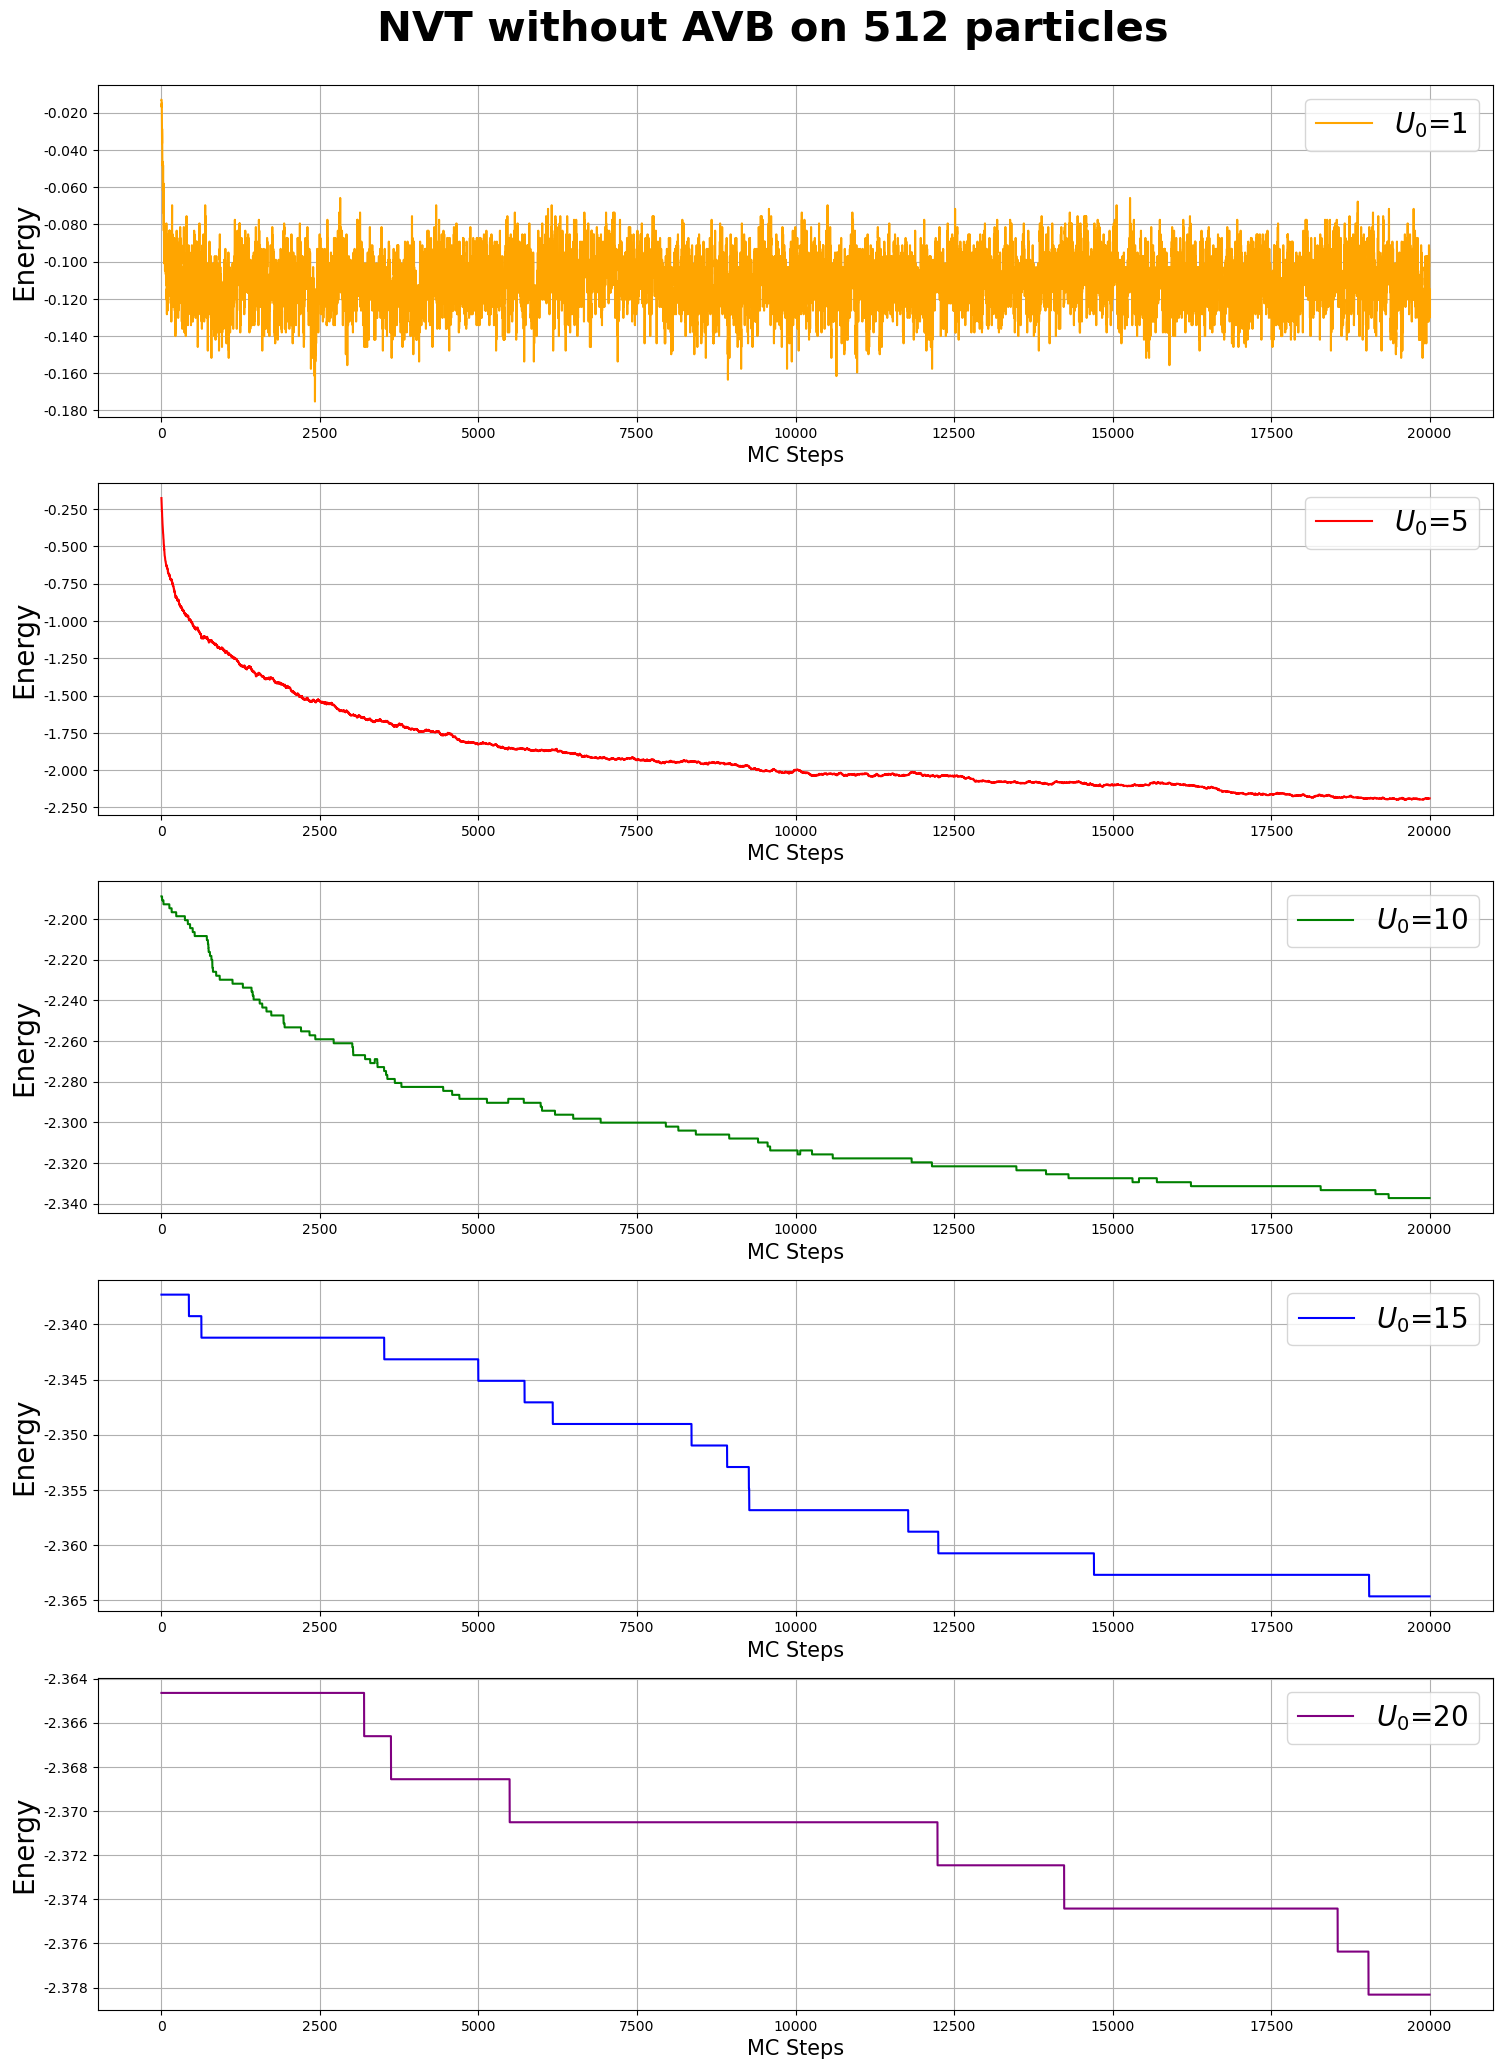

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value:.3f}'

plt.figure(figsize=(18,25))
fase = ["1", "5", "10", "15", "20" ]
colors = ['orange','red', 'green', 'blue', 'purple']
for i in range (5) :
    index, value= np.loadtxt("plot/N512_20K/mu=" + fase[i]+ "_energy_0.dat", usecols=(0, 1), unpack=True, delimiter=' ')
    plt.subplot(5, 1, i+1)
    plt.plot(index,value, label = '$U_0$=' + fase[i], color=colors[i])
    plt.grid(True)
    plt.ylabel('Energy', fontsize=20)
    #plt.xlim(right=5000)
    plt.xlabel('MC Steps', fontsize=15)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
    plt.legend(fontsize="20")
    
plt.suptitle('NVT without AVB on 512 particles', fontsize=30, y=0.91, fontweight='bold')
plt.show()

Dai plot, possiamo osservare la progressiva stabilizzazione dell'energia che suggerisce che il sistema sta lentamente termalizzando verso uno stato ad energia minore, perciò di equilibrio. Si nota che per valori del potenziale maggiori, in cui quindi la buca è più profonda e la temperatura del sistema è più bassa, vediamo un comportamento a gradini. Questo suggerisce che il sistema sta passando tra stati metastabili attraverso transizioni discrete rimanendo bloccato in minimi di energia locali. Ciò rappresenta proprio il bloccaggio del sistema in configurazioni di particelle legate che difficilmente vengono rotte in cui, quindi, una significativa riorganizzazione del sistema accade con bassa frequenza.

Infatti, a basse temperature il sistema ha meno energia termica per esplorare configurazioni differenti e questo porta ad osservare lunghi periodi dove il sistema rimane bloccato in stati metastabili seguiti da improvvise transizioni quando finalmente una mossa è accettata. Le sticky hard spheres mostrano forte attrazione in short range e quindi, a basse T, tendono a formare strutture dense e compatte. \
D'altro canto, ad alte T (ad esempio, curva rossa e verde) il sistema ha molta più energia termica per esplorare in maniera continua lo spazio delle fasi e di questo se ne ha una dimostrazione nel rilassamento di energia più liscio. Per la curva arancione, invece, l'energia termica è così alta che le fluttuazioni intorno allo stato di equilibrio diventano molto importanti.

Andiamo ora a riportare, invece, i risultati sullo stesso sistema di 512 particelle utilizzando l'AVB MC.

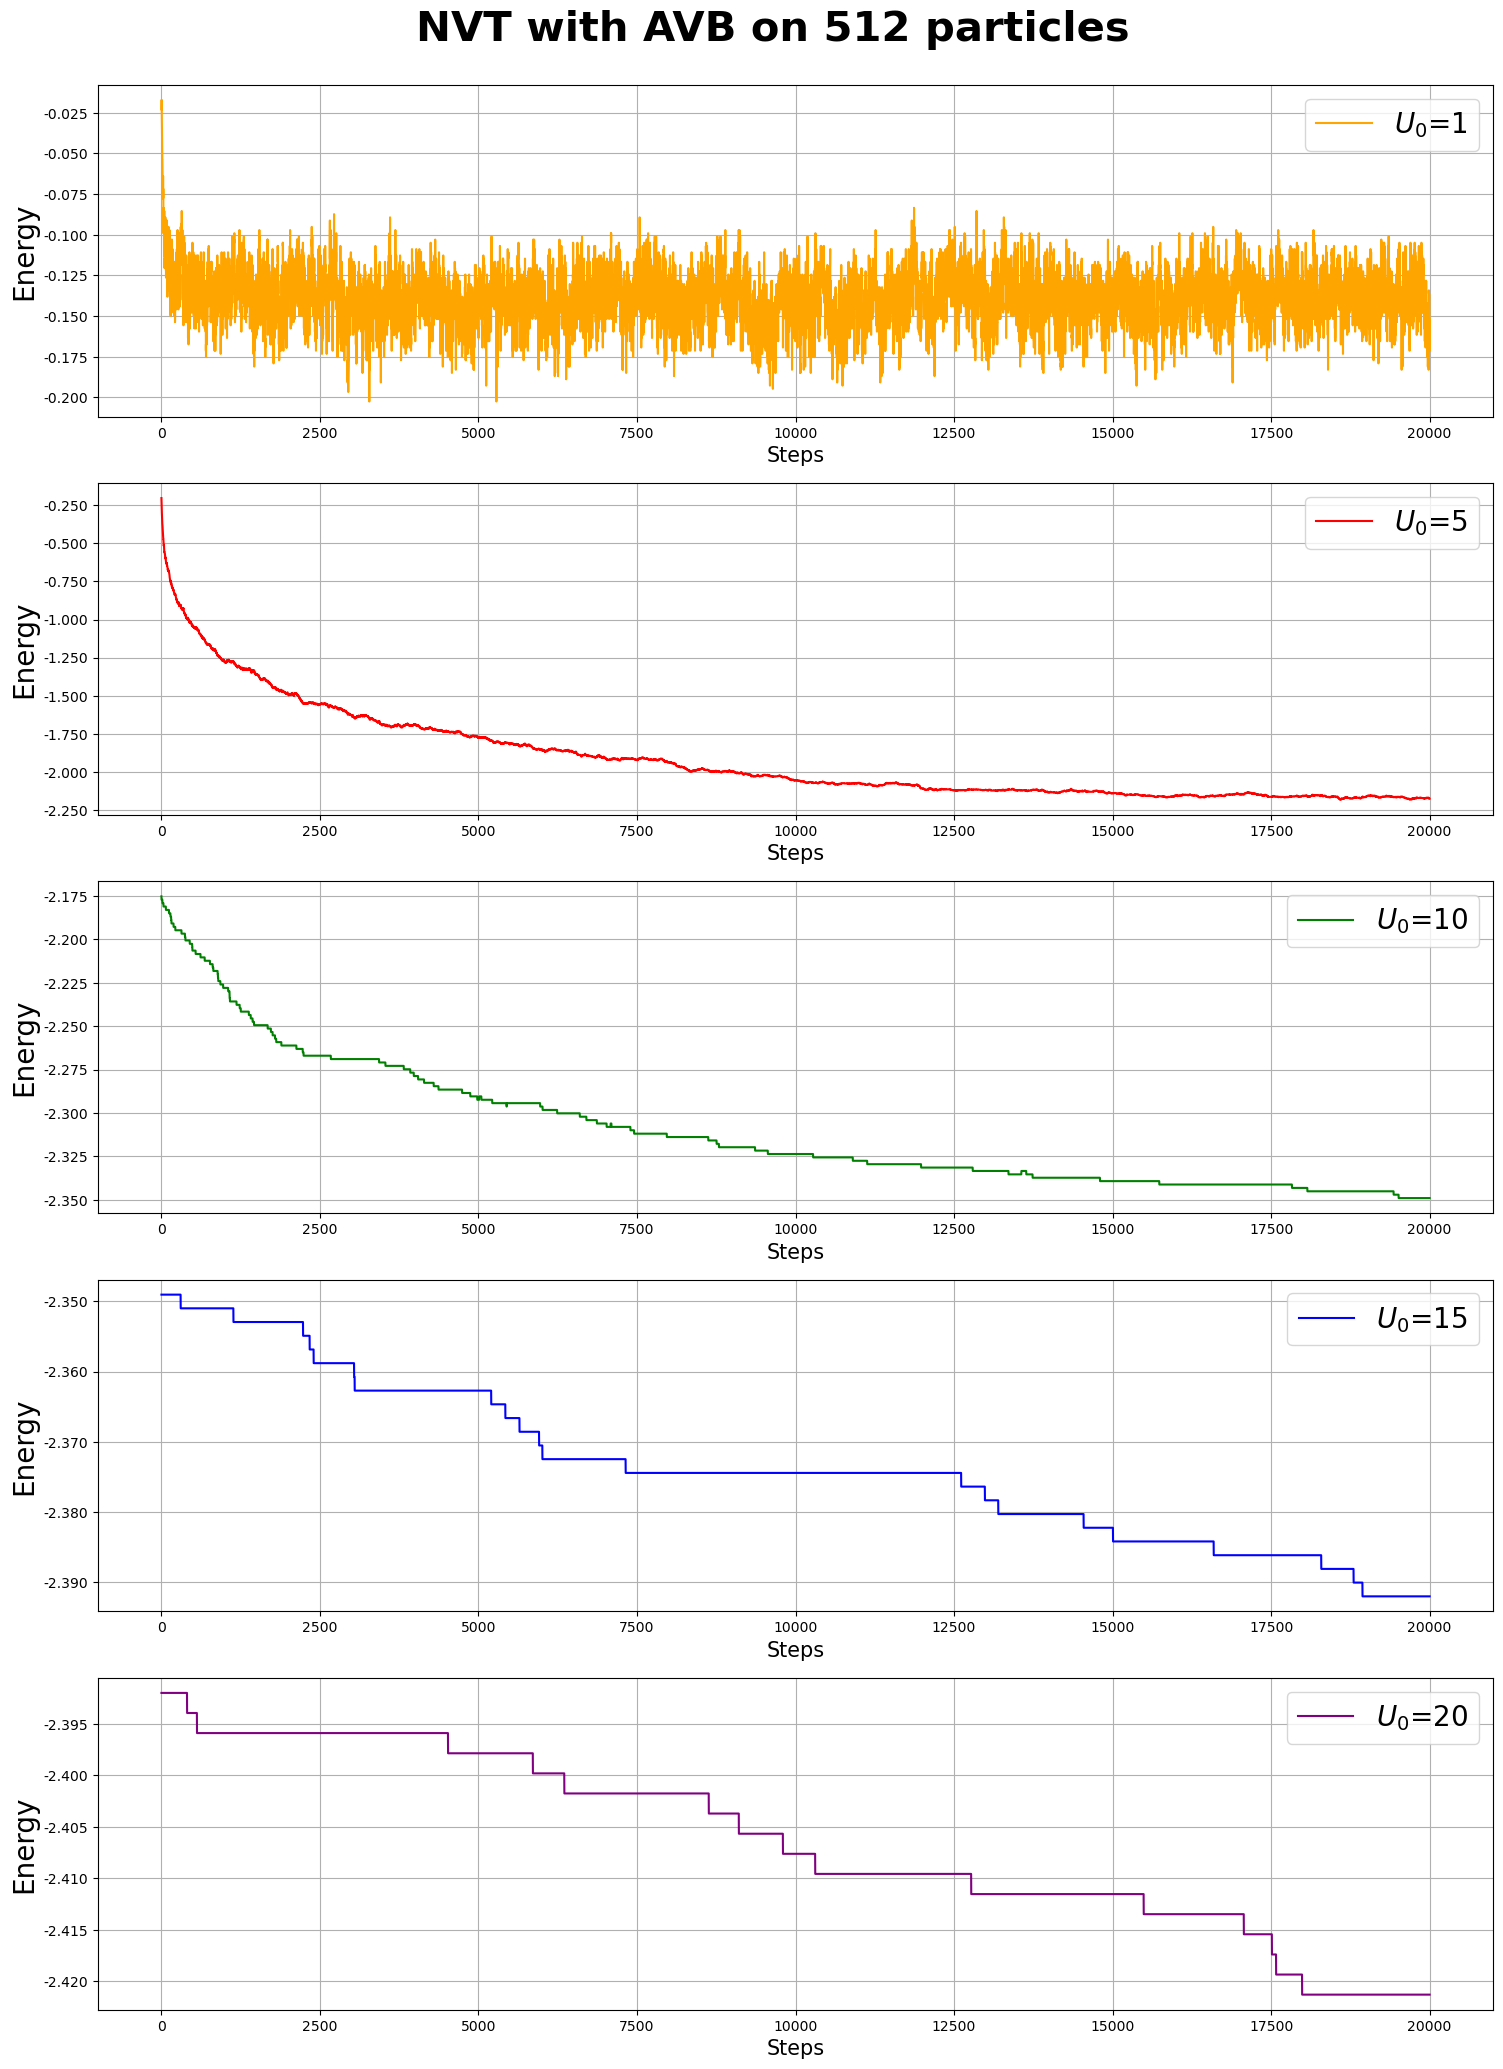

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value:.3f}'

plt.figure(figsize=(18,25))
fase = ["1", "5", "10", "15", "20" ]
colors = ['orange','red', 'green', 'blue', 'purple']
for i in range (5) :
    index, value= np.loadtxt("plot/N512_20K/mu=" + fase[i]+ "_energy_2.dat", usecols=(0, 1), unpack=True, delimiter=' ')
    plt.subplot(5, 1, i+1)
    plt.plot(index,value, label = '$U_0$=' + fase[i], color=colors[i])
    plt.grid(True)
    plt.xlabel('MC Steps', fontsize=15)
    #plt.xlim(right=5000)
    plt.ylabel('Energy', fontsize=20)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
    plt.legend(fontsize="20")
    
plt.suptitle('NVT with AVB on 512 particles', fontsize=30, y=0.91, fontweight='bold')
plt.show()

Ora che abbiamo i plot NVT utilizzando AVB MC, possiamo compararli con la stessa simulazione effettuata senza biasing per capire l'effetto dell'aggregation volume bias.\
Innanzitutto, la simulazione biased mostra una più pronunciata e costante decrescita di energia: il sistema raggiunge stati ad energia minore, rispetto al caso unbiased, e lo fa in maniera più efficiente. La tecnica di biasing sta, quindi, effettivamente incrementando l'efficienza di campionamento dello spazio delle fasi del sistema. \
A basse temperatura, plot blu e viola, il comportamento a gradini è ancora presente ma le transizioni sono più frequenti e liscie; questo mostra che l'AVB aiuta a migliorare il sampling, permettendo al sistema di uscire dai minimi locali di energia dovuti alla formazione di cluster più velocemente. Questo è esattamente il risultato del biasing sull'acceptance delle mosse $in \rightarrow out$ che favorisce le mosse di rottura legame, e quindi ottimizza l'esplorazione in energia.

I casi ad alta T, plot arancione, rosso e verde, mostrano un comportamento simile alla simulazione senza bias ma termalizzano a valori di energia leggermente minori. Questo mostra che l'aggregation volume bias porta ad un più efficiente campionamento dello spazio delle configurazioni anche a temperature moderate, anche se decisamente brilla a basse T accelerando l'equilibratura del sistema verso stati ad energia ancora minore.


C'è da sottolineare come il run time della simulazione senza AVB è stato di circa 20 minuti, mentre inserendo il bias di circa 22 minuti. Notiamo, quindi, come l'attivazione dell'AVB comporti un costo computazionale aggiuntivo del solo 10% rispetto al tempo di computazione della simulazione MC standard, ma i vantaggi in termini di termalizzazione sono evidenti.

Per andare meglio a comparare i risultati ottenuti con e senza AVB possiamo confrontare uno ad uno i plot così da avere una più immediata visualizzazione del guadagno portato dal biasing.

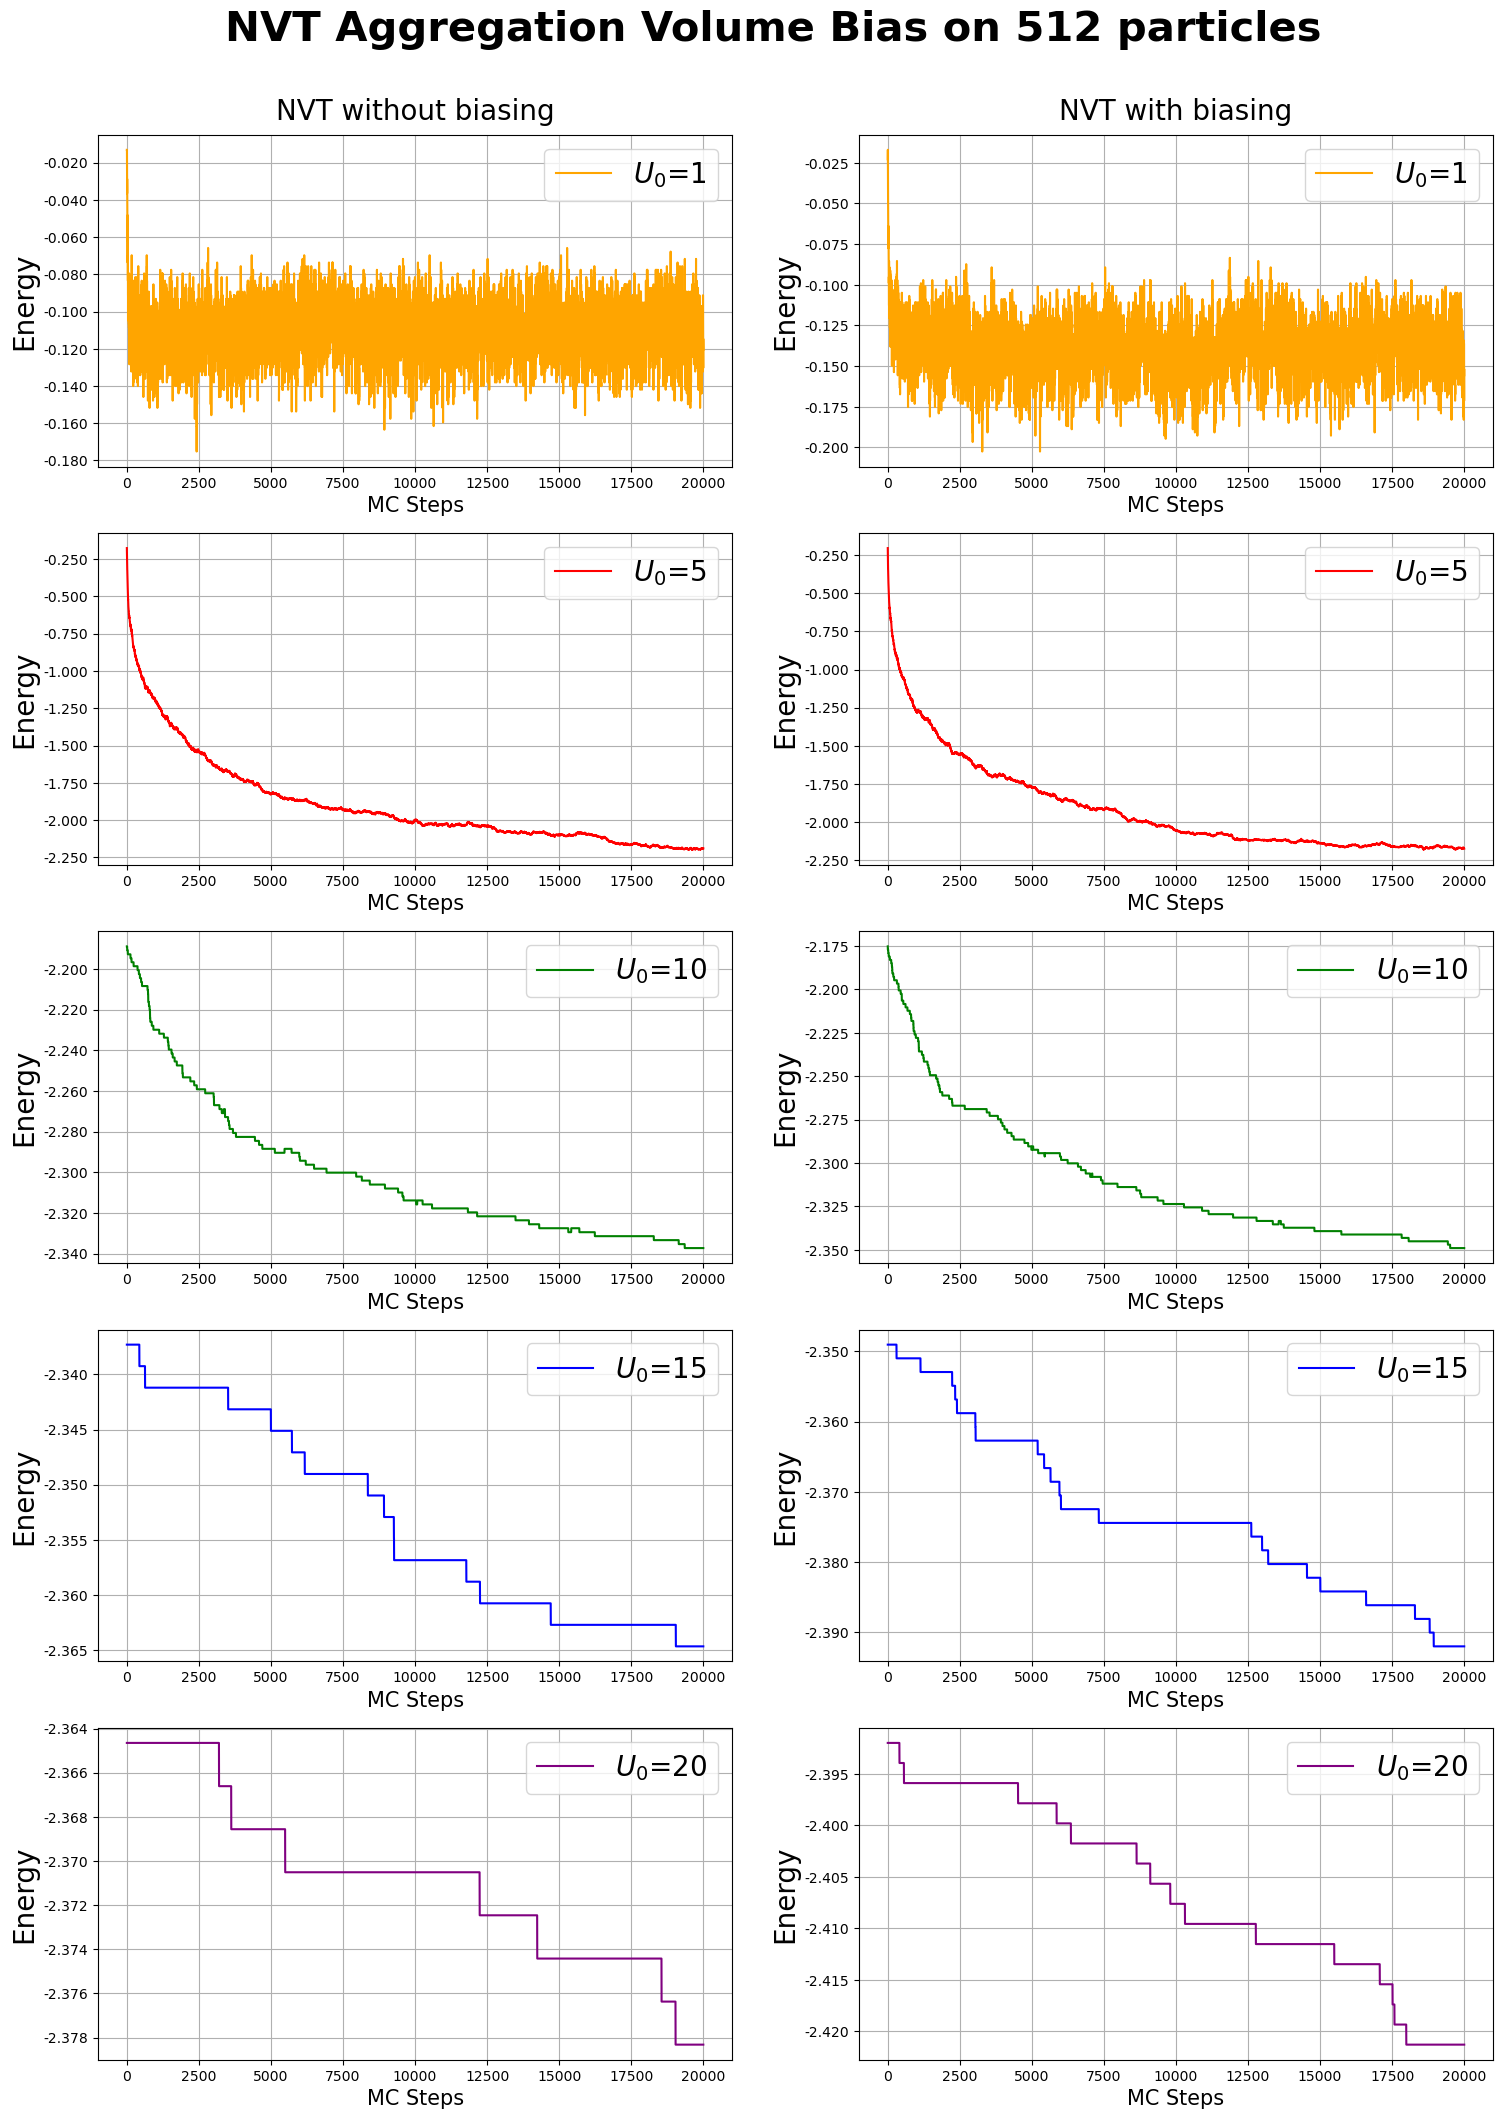

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value:.3f}'

plt.figure(figsize=(18,25)) #20,20
mu_value = ["1", "5", "10", "15", "20" ]
colors = ['orange','red', 'green', 'blue', 'purple']
simulations = ["0", "2"]
titles = ["NVT without biasing", "NVT with biasing"]
counter = 1
for i in range (5) :
    for j in range (2):
        index, value= np.loadtxt("plot/N512_20K/mu=" + mu_value[i]+ "_energy_" + simulations[j] +".dat", usecols=(0, 1), unpack=True, delimiter=' ')
        plt.subplot(5, 2, counter) #default i+1
        plt.plot(index,value, label = '$U_0$=' + mu_value[i], color=colors[i])
        plt.grid(True)
        plt.xlabel('MC Steps', fontsize=15)
        #plt.xlim(right=5000)
        plt.ylabel('Energy', fontsize=20)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
        if (counter<3):
            plt.title(titles[j], fontsize = 20, y=1.02)
        plt.legend(fontsize="20")
        counter += 1
    
plt.suptitle('NVT Aggregation Volume Bias on 512 particles', fontweight='bold', fontsize=30, y=0.93)
plt.show()

Ora che abbiamo un confronto diretto tra le simulazione con e senza AVB, possiamo stimare lo speedup for ogni valore di $\beta U_0$.\
Lo speedup può essere definito come il rapporto tra il tempo, quindi i montecarlo steps, necessari alla simulazione unbiased per raggiungere un certo valore di energia di equilibrio rispetto agli step necessari alla simulazione biased per ottenere un valore simile. Matematicamente, quindi:

$$Speedup = \frac{MC \, Steps_{\,unbiased}}{MC \, Steps_{\,biased}}$$

La comparazione conferma visivamente che le simulazione con bias raggiungono stati ad energia minore in maniera più veloce rispetto a quelle unbiased. Da ciò sorge un problema nel calcolo dello speedup: le simulazioni convergono a valori diversi di energia; in particolare l'AVB fa convergere ad energie inferiori. Allora, per stimare lo speedup, si è scelto di estrarre un valore approssimato del numero di step per cui entrambe le simulazioni raggiungono un valore simile e stabile di energia, ossia caratterizzato da un andamento pressochè piatto a plateu.

I risultati ottenuti sono riassunti nella seguente tabella:

| U | Energy value | MC Steps (Unbiased) | MC Steps (Biased) | Speedup |
| :--------------- | ---------------------- | ---------------------- | ------------------- | -------- |
| 1 | -0.120 | 20000 | 20000 | **1.0x** |
| 5 | -2.125 | 17500 | 12500 | **1.4x** |
| 10 | -2.325 | 15000 | 10000 | **1.5x** |
| 15 | -2.361 | 13000 | 5000 | **2.6x** |
| 20 | ----- | 8500 | 3000 | **2.8x** |


dove U si riferisce a $\beta \, U_0$, l'energy value è il valore di energia preso come reference per ricavare il numero di step necessari alle due simulazioni per raggiungerlo mentre lo Speedup è calcolato come sopra riportato. \
Per la simulazione a più basse energia, $\beta \, U_0 = 20$, non è stato possibile estrapolare un valore di step affinchè le due simulazioni raggiungessero lo stesso valore di energia in quanto la simulazione biased parte da valori di energia già inferiori alla simulazione senza bias e tende ad equilibrarsi verso energie ancora piu basse. Perciò, si è scelto di calcolare lo speedup prendendo come riferimento il numero di passi per raggiungere un equilibrio termodinamico del sistema, nonostante quello del sistema bias sia a minori energie dell'equilibrio per la simulazione unbiased. Possiamo, quindi, capire subito dalla discrepanza tra i valori di energia di equilibrio raggiunti come la simulazione biased sia più efficiente e con un sampling dello spazio delle configurazioni più ampio. \
I risultati riportati in tabella mostrano chiaramente come l'aggregation volume bias accelleri significativamente la equilibratura del sistema sia a temperature alte che basse; alle T inferiori, però, porta un notevole vantaggio essendo oltre 2.5 volte più efficiente che la sua controparte unbiased. \
L'AVB porta chiaramente una ottimizzazione della simulazione migliorando sia l'efficienza di campionamento che l'accuratezza della termalizzazione raggiunta.

Possiamo fare lo stesso confronto tra simulazione con e senza aggregation volume bias per un sistema di 1000 sticky hard spheres, 10 in ognuna delle tre direzioni dello spazio, mantenendo però costante la densità del sistema e i parametri del potenziale di interazione.

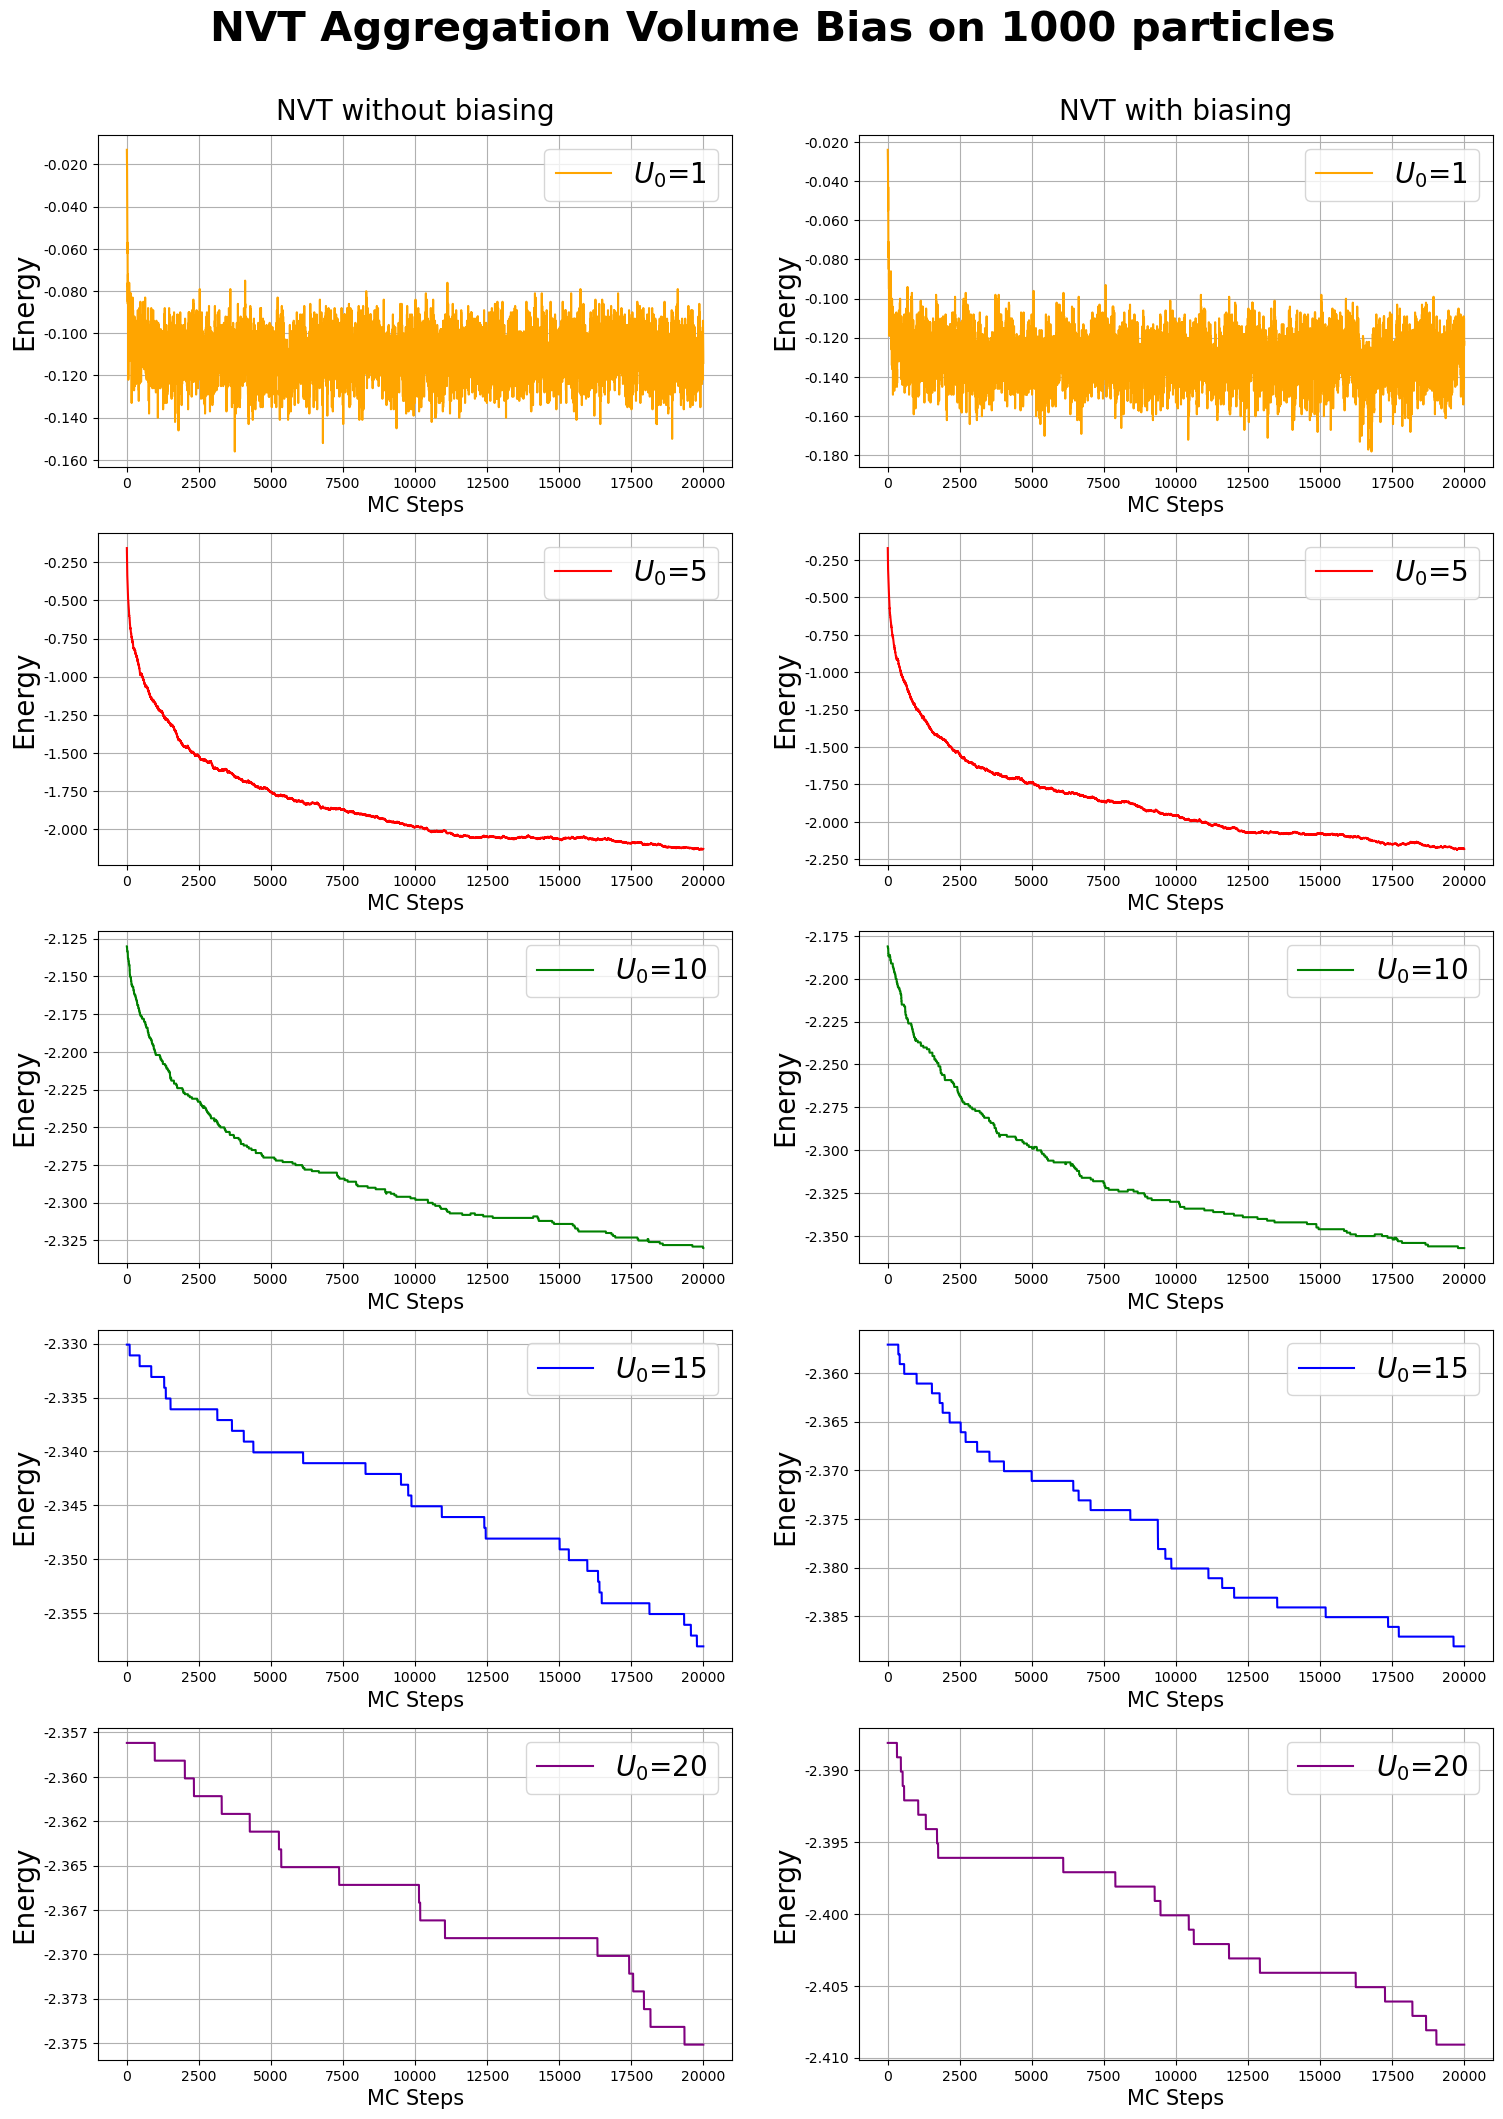

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value:.3f}'

plt.figure(figsize=(18,25)) #20,20
mu_value = ["1", "5", "10", "15", "20" ]
colors = ['orange','red', 'green', 'blue', 'purple']
simulations = ["0", "2"]
titles = ["NVT without biasing", "NVT with biasing"]
counter = 1
for i in range (5) :
    for j in range (2):
        index, value= np.loadtxt("plot/N1000_20K/mu=" + mu_value[i]+ "_energy_" + simulations[j] +".dat", usecols=(0, 1), unpack=True, delimiter=' ')
        plt.subplot(5, 2, counter) #default i+1
        plt.plot(index,value, label = '$U_0$=' + mu_value[i], color=colors[i])
        plt.grid(True)
        plt.xlabel('MC Steps', fontsize=15)
        #plt.xlim(right=5000)
        plt.ylabel('Energy', fontsize=20)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
        if (counter<3):
            plt.title(titles[j], fontsize = 20, y=1.02)
        plt.legend(fontsize="20")
        counter += 1
    
plt.suptitle('NVT Aggregation Volume Bias on 1000 particles', fontweight='bold', fontsize=30, y=0.93)
plt.show()


Confrontando le simulazioni con 512 e 1000 particelle, possiamo osservare alcune differenze chiave. I trend generali rimangono gli stessi: la simulazione con AVB converge ad energie inferiori e più velocemente rispetto alla simulazione unbiased, soprattutto a bassa temperatura. In realtà, però, Il bias rende più efficiente il campionamento dello spazio delle configurazioni anche a T più alte. \
Per il sistema di 1000 particelle, l'equilibrio è raggiunto più gradualmente, soprattutto a basse T. Ciò ha senso dato che avere un sistema con un maggior numero di particelle vuol dire dover considerare più interazioni: tutto ciò implica un landscape di energia più complesso in cui il sistema ha bisogno di più MC steps per esplorare tutte le possibili configurazioni prima di raggiungere un equilibrio. 

Per quanto riguarda lo speedup, nel sistema a 512 particelle esso variava tra 1.5x e 2.8x in funzione della temperatura. Per il sistema a 1000, l'AVB sicuramente migliora l'efficienza di campionamento, ma lo speedup relativo potrebbe essere leggermente inferiore a causa della più grande dimensione del sistema.\
Possiamo, quindi, stimare lo speedup come fatto in precedenza ricavando dai grafici il valore di MC steps necessari alla simulazione biased ed unbiased per raggiungere un valore simile e stabile di energia. Riportiamo i risultati nella seguente tabella:

| U | Energy value | MC Steps (Unbiased) | MC Steps (Biased) | Speedup |
| :--------------- | ---------------------- | ---------------------- | ------------------- | -------- |
| 1 | -0.120 | 20000 | 20000 | **1.0x** |
| 5 | -2.125 | 18500 | 15000 | **1.2x** |
| 10 | -2.310 | 11500 | 7000 | **1.6x** |
| 15 | ----- | 13000 | 6000 | **2.2x** |
| 20 | ----- | 8000 | 3250 | **2.5x** |

Come nel caso precedente, per i valori più bassi di T le due simulazioni convergono a diversi valori di energia e, perciò, per stimare lo speedup sono stati considerati diversi valori di energia di riferimento a cui il sistema termalizza. \
Possiamo osservare come gli speedup siano molto simili a quelli del sistema di 512 particelle. L'AVB riduce in maniera consistente il numero di step necessari per raggiungere l'equilibrio ad ognuna delle cinque temperature studiate. Lo speedup varia tra 1.2x e 2.5x quindi, nonostante sia leggermente inferiore al sistema con N=512, questo dimostra come anche in un sistema ben più grande il biasing rimane estremamente vantaggioso per migliorare l'efficienza della simulazione.

Tornando al sistema di 512 particelle, possiamo indagare meglio il raggiungimento di un equilibrio termodinamico non "limitandoci" a 20000 MC steps, ma andando fino a 50000 steps ancora una volta salvando i valori istantanei di energia (ossia ad ogni step).  \
È da sottolineare come questa simulazione sia assolutamente la più dispendiosa in termini di calcoli e tempo computazionale.

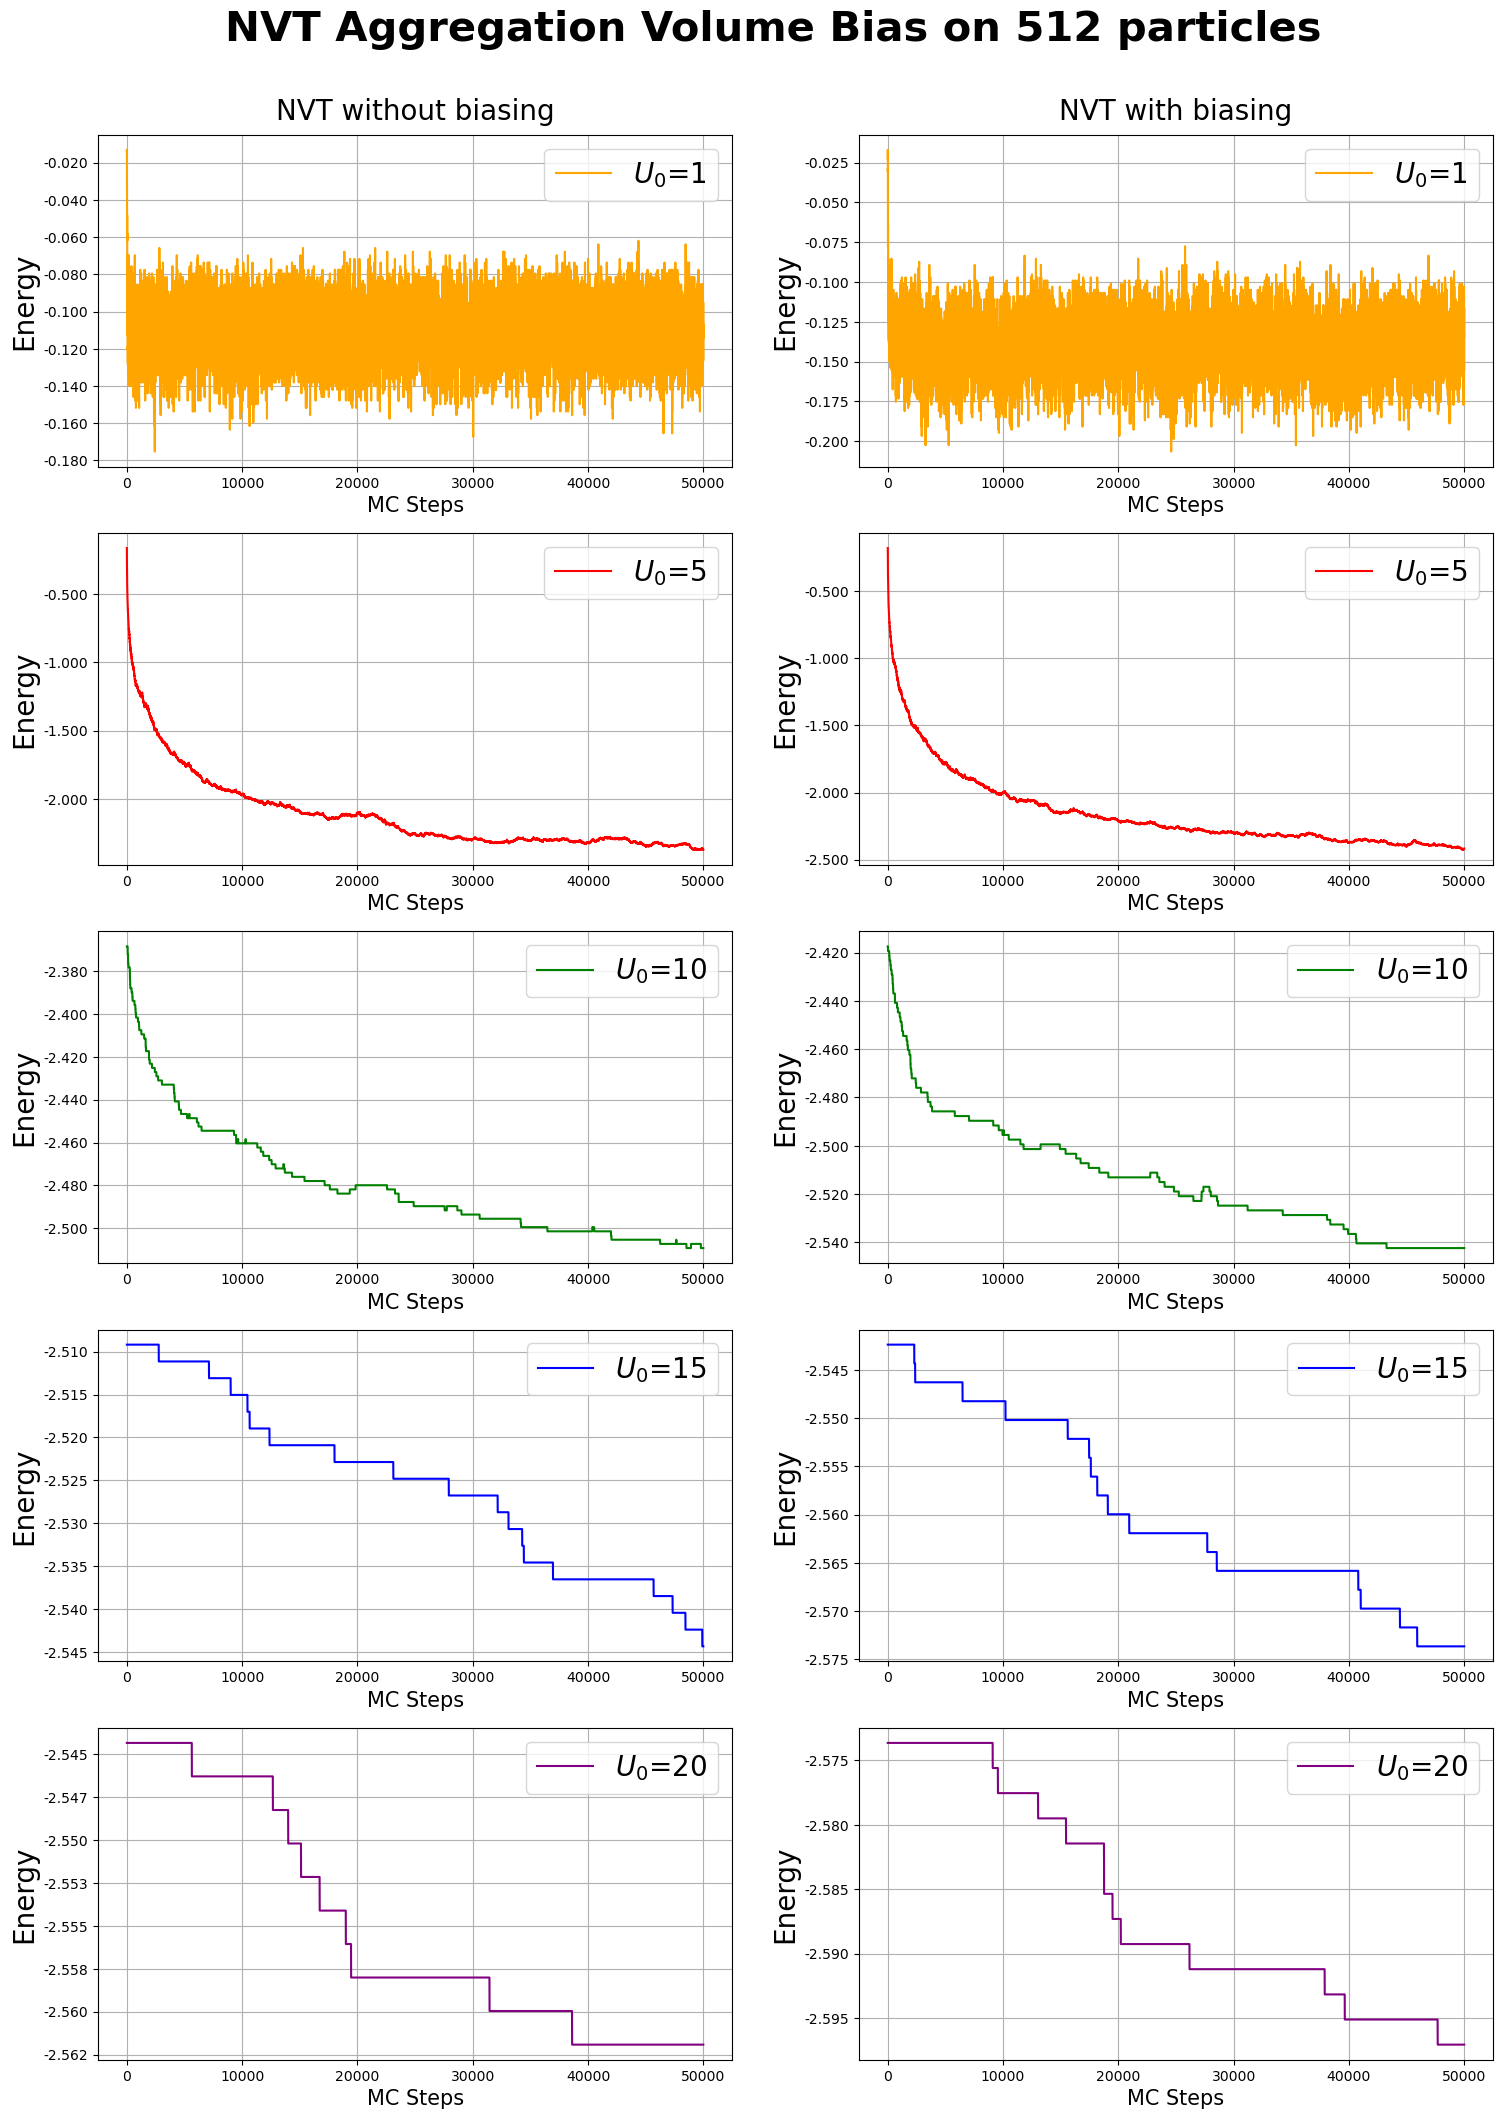

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value:.3f}'

plt.figure(figsize=(18,25)) #20,20
mu_value = ["1", "5", "10", "15", "20" ]
colors = ['orange','red', 'green', 'blue', 'purple']
simulations = ["0", "2"]
titles = ["NVT without biasing", "NVT with biasing"]
counter = 1
for i in range (5) :
    for j in range (2):
        index, value= np.loadtxt("plot/N512_50K/mu=" + mu_value[i]+ "_energy_" + simulations[j] +".dat", usecols=(0, 1), unpack=True, delimiter=' ')
        plt.subplot(5, 2, counter) #default i+1
        plt.plot(index,value, label = '$U_0$=' + mu_value[i], color=colors[i])
        plt.grid(True)
        plt.xlabel('MC Steps', fontsize=15)
        #plt.xlim(right=5000)
        plt.ylabel('Energy', fontsize=20)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
        if (counter<3):
            plt.title(titles[j], fontsize = 20, y=1.02)
        plt.legend(fontsize="20")
        counter += 1
    
plt.suptitle('NVT Aggregation Volume Bias on 512 particles', fontweight='bold', fontsize=30, y=0.93)
plt.show()

Estendendo la simulazione Montecarlo da 20000 a 50000 steps, possiamo ottenere informazioni sul comportamento su lunghi tempi del sistema. \
Il trend generale già osservato fino a 20000 passi continua: l'energia continua a decrescere oltre i 20000 passi, ma con un rate più lento. È evidente come nei plot verde, blu e viola il sistema richiedeva tempi più lunghi per essere equilibrato dato che l'energia a 20000 steps continua a decrescere con regolarità. 

Il biasing porta, anche in questo caso, ad incrementare in maniera significativa l'equilibratura del sistema: nelle simulazioni con l'AVB il sistema raggiunge stati ad energia minore in modo più efficente. Le energie finali delle simulazioni biased, infatti, tendono ad essere sempre minori che le loro controparti delle simulazioni unbiased il che suggerisce che il bias aiuta ad esplorare configurazioni a più bassa energia più velocemente. \
Perciò, il biasing rimane una strategia efficace per ridurre i tempi di termalizzazione dato che anche sulle run più lunghe, le simulazioni biased tendono all'equilibrio più velocemente.

## 5. Conclusioni

In questa relazione, abbiamo studiato l'efficacia dell'algoritmo Aggregation Volume Bias Monte Carlo (AVB MC) applicato a un sistema di Sticky Hard Spheres. I risultati ottenuti mostrano chiaramente che l'AVB MC migliora significativamente l'efficienza del campionamento dello spazio delle fasi rispetto all'algoritmo Monte Carlo standard di Metropolis. \
L'algoritmo AVB MC si è rivelato particolarmente utile per superare gli stati metastabili dovuti alle configurazioni legate, che rappresentano una sfida nei sistemi fortemente associati. L'introduzione di mosse biased ha permesso di esplorare più rapidamente lo spazio delle fasi, migliorando la qualità delle medie statistiche ottenute.

L'AVB MC ha dimostrato di accelerare la termalizzazione del sistema, specialmente a basse temperature, dove il sistema tende a rimanere intrappolato in configurazioni legate. Lo speedup varia da 1.2x a 2.8x, con un miglioramento più marcato a temperature più basse. Le simulazioni con AVB MC raggiungono stati ad energia più bassa rispetto alle simulazioni senza bias, indicando un campionamento più efficace delle configurazioni del sistema, e li raggiungono più velocemente. \
 Per quanto riguarda il costo computazionale, l'overhead computazionale introdotto dall'AVB MC è trascurabile, con un aumento del tempo di simulazione di circa il 10%, a fronte di un significativo miglioramento dell'efficienza.

Le simulazioni sono state limitate a sistemi di dimensioni relativamente piccole (512 e 1000 particelle) e a particelle dure con una parte attrattiva. Più approfonditi studi potrebbero estendere l'analisi a sistemi di dimensioni maggiori e con diversi tipi di potenziali di interazione per testare la versatilità e la generalità dei risultati ottenuti implementando l'AVB. Come già fatto da Chen and Siepmann nel 2001 si potrebbero, poi, esplorare ulteriori ottimizzazioni delle mosse di biased per migliorare ancora di più l'efficienza del campionamento. 
